# Table of Contents
 <p>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\yvec}{\mathbf{y}}
    \newcommand{\muvec}{\mathbf{\mu}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\partial}
    \newcommand{\sentinels}{\mathbf{\boundary}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\linavg}{\bar{\tau}}
    \newcommand{\invvar}{\tau^{IV}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
$$

In [2]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
geordd_root = "../"

"../"

In [4]:
X_LA = readcsv(geordd_root*"Mississippi_data/X_LA.csv")
X_MS = readcsv(geordd_root*"Mississippi_data/X_MS.csv")
LA_dist = readcsv(geordd_root*"Mississippi_data/LA_Dist.csv")
MS_dist = readcsv(geordd_root*"Mississippi_data/MS_Dist.csv")
sentinels = readcsv(geordd_root*"Mississippi_data/sentinels.csv")
border = readcsv(geordd_root*"Mississippi_data/border.csv")
;

In [5]:
Y_MS = zeros(length(MS_dist))
Y_LA = zeros(length(LA_dist))
;

In [94]:
include(geordd_root*"src/GeoRDD.jl")


Use "MultiGPCovars{MT,KT1,KT2}(...) where {MT,KT1,KT2}" instead.


GeoRDD

In [150]:
k = SEIso(log(100e3), 0.0)
k2 = k + GeoRDD.ConstantKernel(log(100.0))

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [11.5129, 0.0]
  Type: GeoRDD.ConstantKernel, Params: [4.60517]


In [151]:
gp_MS = GP(X_MS, Y_MS, MeanZero(), k2, 0.0)
gp_LA = GP(X_LA, Y_LA, MeanZero(), k2, 0.0)
;

In [152]:
using PyCall
@pyimport mpl_toolkits.axes_grid1.anchored_artists as anchored_artists

In [153]:
function sim_null(gpT::GPE, gpC::GPE)
    yNull = zeros(gpT.nobsv + gpC.nobsv)
    Xnull = [gpT.X gpC.X]
    gpNull = GPE(Xnull, yNull, MeanZero(), gpT.k.kerns[1], gpT.logNoise)
    MVNnull = MultivariateNormal(zeros(gpNull.nobsv), gpNull.cK)
    Yrand = rand(MVNnull)
    return Yrand
end

sim_null (generic function with 1 method)

In [171]:
srand(4)
τ = 1.5
Ysim = sim_null(gp_MS, gp_LA)
Ysim[1:gp_MS.nobsv] .+= τ
Ysim_MS = Ysim[1:gp_MS.nobsv]
Ysim_LA = Ysim[gp_MS.nobsv+1:end]
minY = minimum(Ysim)
maxY = maximum(Ysim)
gp_MS.y = Ysim_MS
gp_LA.y = Ysim_LA
GeoRDD.update_mll!(gp_MS)
GeoRDD.update_mll!(gp_LA)
;

In [172]:
GeoRDD.pval_invvar_calib(gp_MS, gp_LA, sentinels)

0.0012598124334212797

In [173]:
@time GeoRDD.boot_chi2test(gp_MS, gp_LA, sentinels, 10000; update_mean=false)

  1.560745 seconds (1.31 M allocations: 303.099 MiB, 2.41% gc time)


0.0018

In [174]:
@time GeoRDD.boot_mlltest(gp_MS, gp_LA, 10000; update_mean=false)

  1.285428 seconds (620.50 k allocations: 213.410 MiB, 1.80% gc time)


0.0016

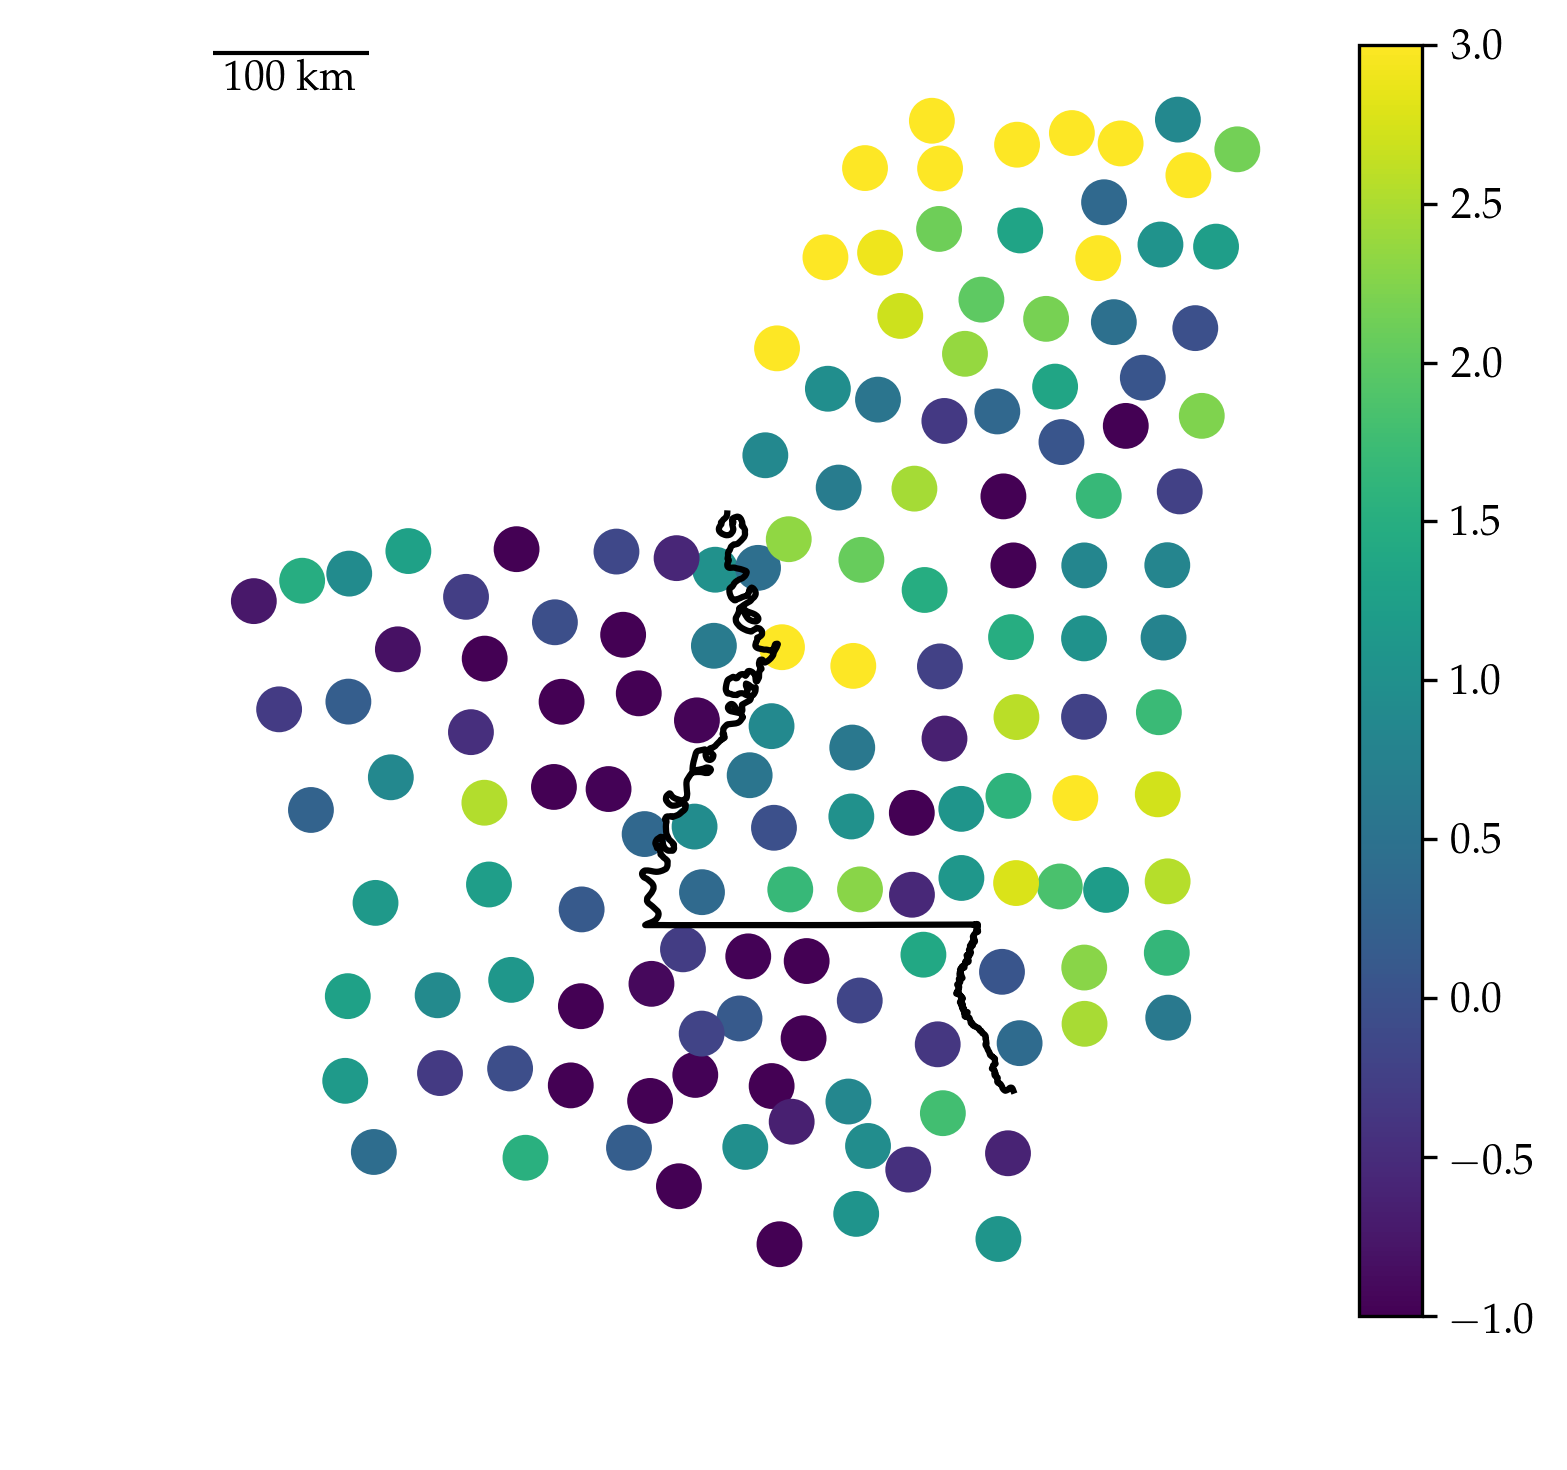

In [187]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
plt.gcf()[:set_size_inches](10.0, 5.0)
plt.subplot(1,2,1)
scale=10
# s=scale*(Ysim_LA-minY)+1
plt.scatter(X_LA[1,:], X_LA[2,:], marker="o", c=Ysim_LA, vmin=-1, vmax=3, s=100)
ax = plt.gca()
ax[:axis]("off")
ax[:axes][:set_aspect]("equal", "datalim")
plt.plot(border[:,1], border[:,2], color="black")
plt.scatter(X_MS[1,:], X_MS[2,:], marker="o", c=Ysim_MS, vmin=-1, vmax=3, s=100)
sizebar = anchored_artists.AnchoredSizeBar(ax[:transData], 100*1000, "100 km", 2; frameon=false)
ax[:add_artist](sizebar)
plt.colorbar()
plt.savefig("../figures/mississippi_sim.png", bbox_inches="tight")
plt.savefig("../figures/mississippi_sim.pdf", bbox_inches="tight")
;

In [176]:
predict_f(gp_MS, sentinels; full_cov=true);
@time predict_f(gp_MS, sentinels; full_cov=false);

  0.027354 seconds (196.22 k allocations: 6.898 MiB, 16.48% gc time)


In [177]:
srand(1)
@time p_invvar_sims = GeoRDD.nsim_invvar_pval(gp_MS, gp_LA, sentinels, 100000; update_mean=false);

 18.412092 seconds (4.92 M allocations: 2.911 GiB, 1.56% gc time)


In [178]:
@time mLL_sims = GeoRDD.nsim_logP(gp_MS, gp_LA, 100000; update_mean=false);

mLL_sim_null = [sim[1] for sim in mLL_sims]
mLL_sim_altv = [sim[2] for sim in mLL_sims]
;

 13.101140 seconds (6.20 M allocations: 2.063 GiB, 1.67% gc time)


In [179]:
@time chi_sims_μ = GeoRDD.nsim_chi(gp_MS, gp_LA, sentinels, 100000; update_mean=false);

 15.001749 seconds (4.04 M allocations: 2.560 GiB, 1.67% gc time)


In [180]:
τ=1.5
srand(1)
@time power_sims = GeoRDD.nsim_power(gp_MS, gp_LA, τ, sentinels, 
                  chi_sims_μ, mLL_sim_altv.-mLL_sim_null, p_invvar_sims,
                  10000;
                  update_mean=false
                  );

 53.263274 seconds (3.22 M allocations: 37.174 GiB, 9.81% gc time)


In [181]:
srand(1)
@time power_sims_null = GeoRDD.nsim_power(gp_MS, gp_LA, 0.0, sentinels, 
                  chi_sims_μ, mLL_sim_altv.-mLL_sim_null, p_invvar_sims,
                  10000;
                  update_mean=false
                  );

 47.995108 seconds (3.12 M allocations: 37.170 GiB, 9.53% gc time)


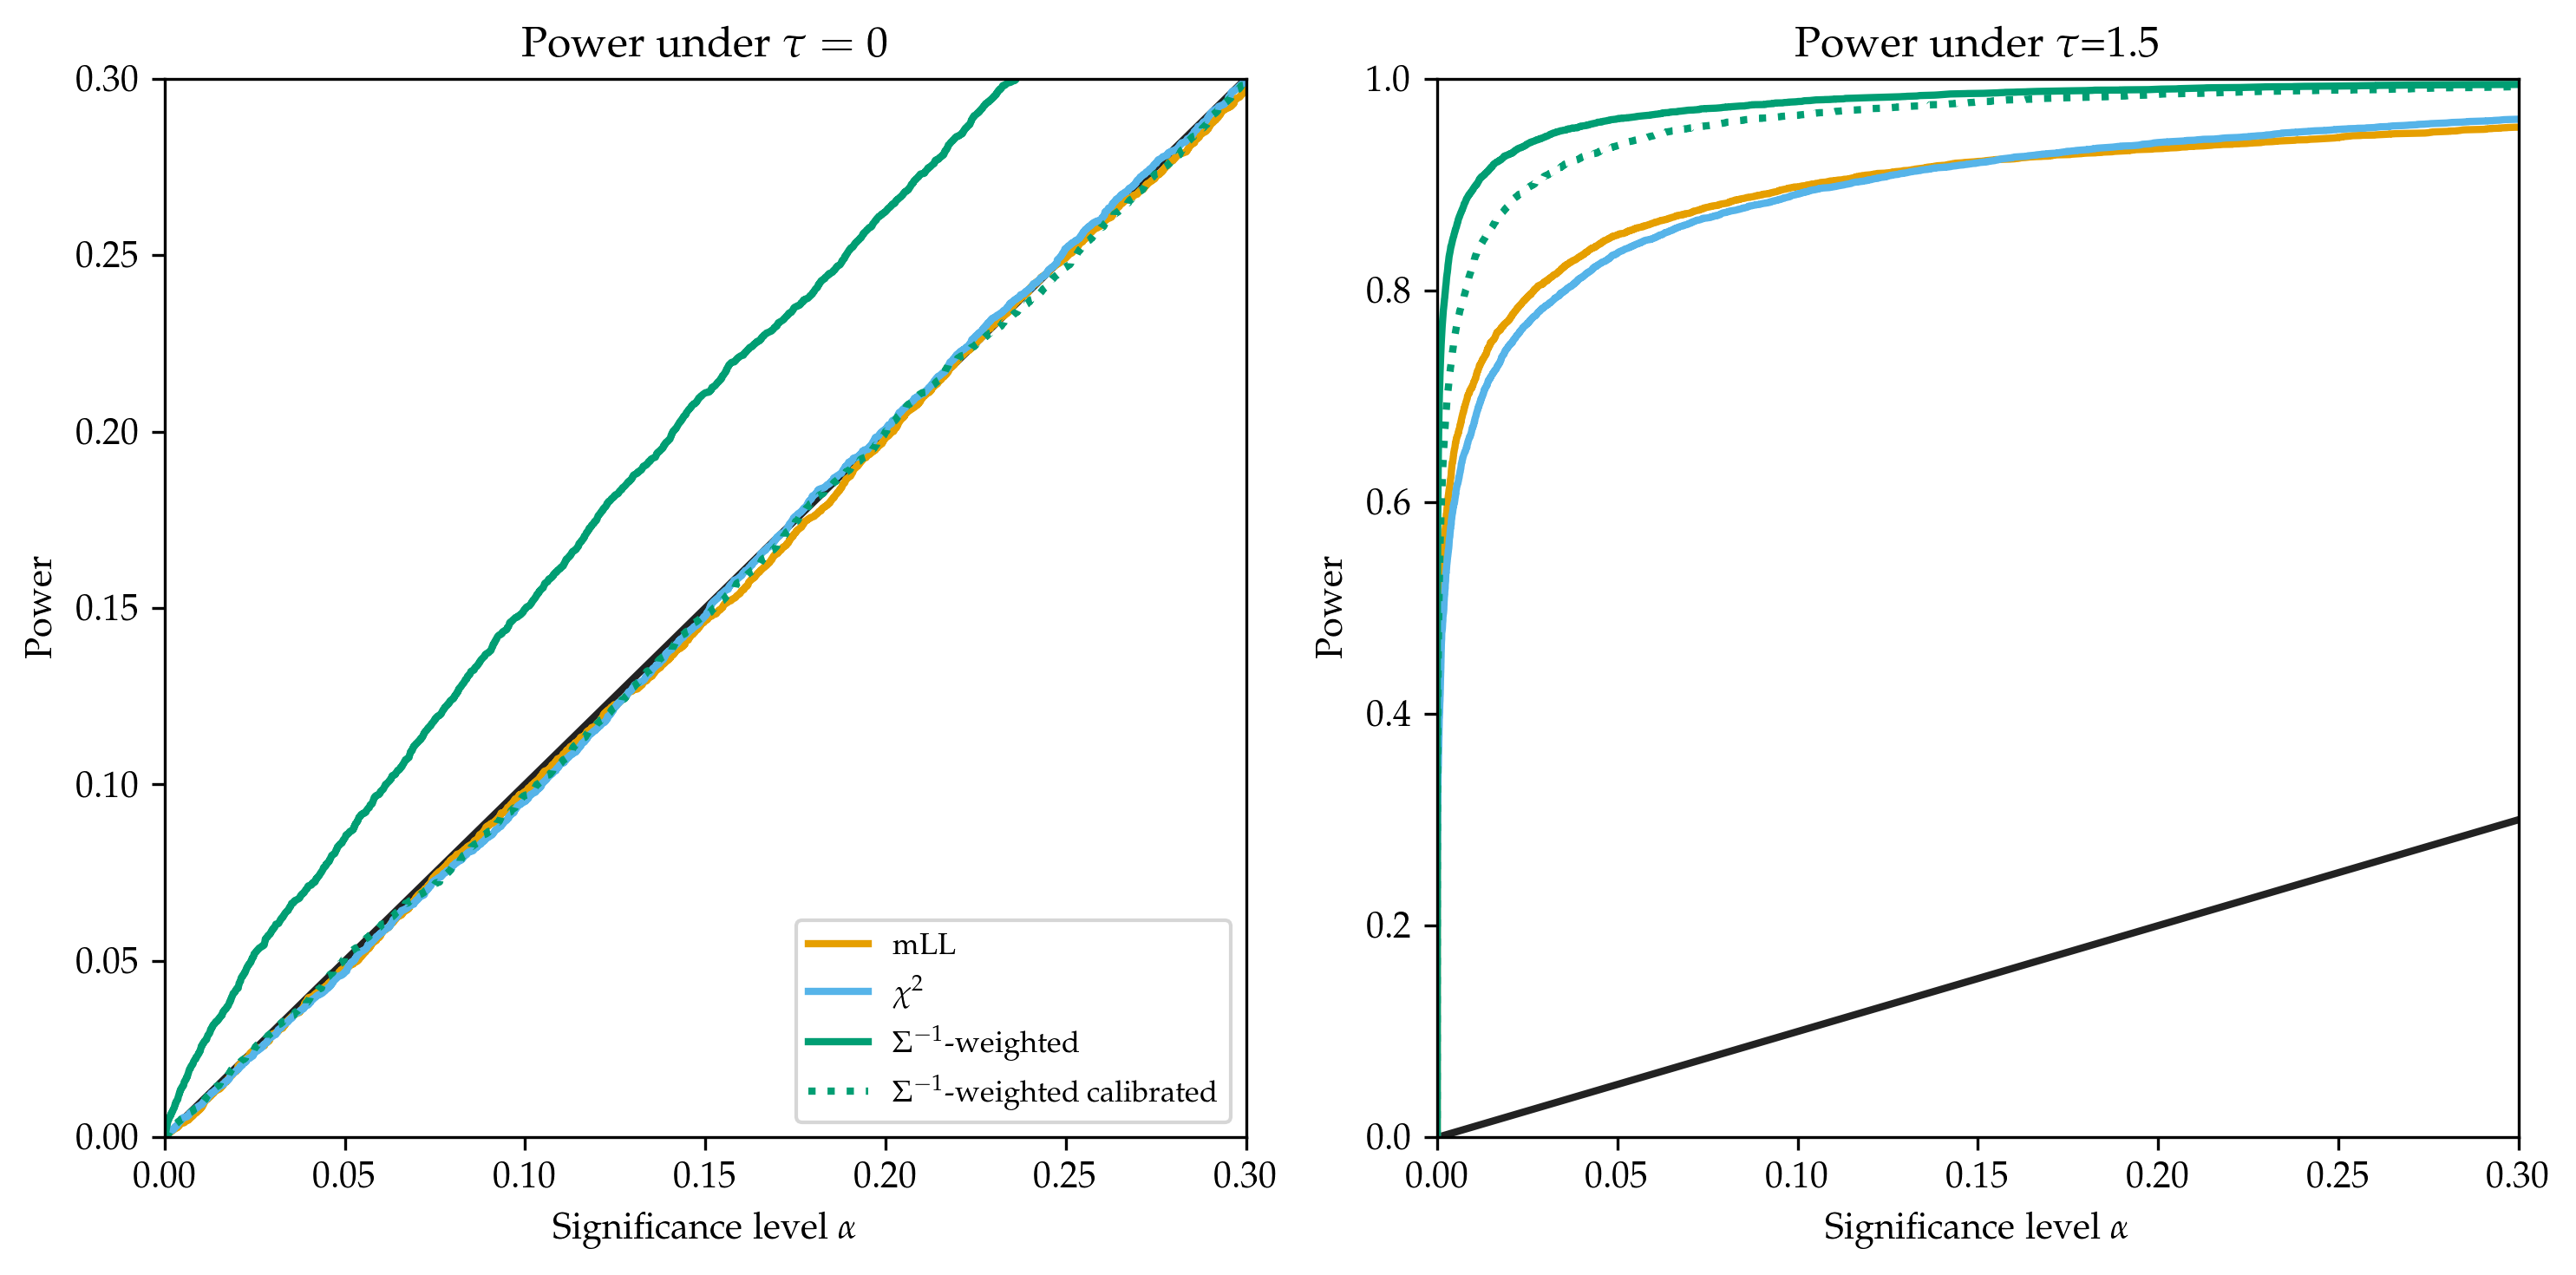

In [182]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
bins=linspace(0,1.1,1000)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([0.0,1.0],[0.0,1.0], color="#222222", linewidth=2)
plt.plot(sort([s[1] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[1],
         label="mLL",
         linewidth=2,
        )
plt.plot(sort([s[2] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[2],
         label=L"\chi^2",
         linewidth=2,
        )
plt.plot(sort([s[3] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[3],
         label=L"$\Sigma^{-1}$-weighted",
         linewidth=2,
        )
# bootstrap calibration
# plt.plot(sort([s[5] for s in power_sims_null]), 
#          linspace(0,1,length(power_sims_null)),
#          color=cbbPalette[3],
#          linestyle=":",  
#          label=L"$\Sigma^{-1}$-weighted calibrated",
#          linewidth=2,
# )
plt.plot(sort([s[5] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[3],
         linestyle=":",  
         label=L"$\Sigma^{-1}$-weighted calibrated",
         linewidth=2,
)
plt.xlabel(L"Significance level $\alpha$")
plt.ylabel("Power")
plt.legend(loc="lower right", fontsize="small")
plt.title(L"Power under $\tau=0$")
plt.xlim(0,0.3)
plt.ylim(0,0.3)

plt.subplot(1,2,2)
plt.plot([0.0,1.0],[0.0,1.0], color="#222222", linewidth=2)
plt.plot(sort([s[1] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[1],
         label="mLL",
         linewidth=2,
        )
plt.plot(sort([s[2] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[2],
         label=L"\chi^2",
         linewidth=2,
        )
plt.plot(sort([s[3] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[3],
         label=L"$\Sigma^{-1}$-weighted",
         linewidth=2,
        )
# bootstrap calibration
# plt.plot(sort([s[5] for s in power_sims]), 
#          linspace(0,1,length(power_sims)),
#          color=cbbPalette[3],
#          linestyle=":",  
#          label=L"$\Sigma^{-1}$-weighted calibrated",
#          linewidth=2,
# )
plt.plot(sort([s[5] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[3],
         linestyle=":",  
         label=L"$\Sigma^{-1}$-weighted calibrated",
         linewidth=2,
)
plt.xlabel(L"Significance level $\alpha$")
plt.ylabel("Power")
# plt.legend(loc="lower right", fontsize="small")
plt.title(@sprintf("Power under \$\\tau\$=%.1f", τ))
plt.xlim(0,0.3)
plt.ylim(0,1.0)
plt.savefig(geordd_root*"figures/power_HT.png")
plt.savefig(geordd_root*"figures/power_HT.pdf")
;

In [183]:
using DataTables
using LaTeXStrings

In [184]:
import DataTables
power_df = DataTables.DataTable()
power_df[:estimator] = LaTeXString[L"Marginal log-likelihood $ $", L"$\chi^2$", L"inverse-variance $\Sigma^{-1}$", 
                        L"bootstrap-calibrated $\Sigma^{-1}$", 
                        L"analytically-calibrated $\Sigma^{-1}$"]
α = 0.05
pval_fmt(pvals, α) = @sprintf("%.3f", mean(p < α for p in pvals))
power_df[:null] = [pval_fmt((ps[i] for ps in power_sims_null), α) for i in 1:5]
power_df[:altv] = [pval_fmt((ps[i] for ps in power_sims), α) for i in 1:5]
power_df

,estimator,null,altv
1,"L""Marginal log-likelihood $ $""",0.048,0.852
2,"L""$\chi^2$""",0.047,0.835
3,"L""inverse-variance $\Sigma^{-1}$""",0.085,0.962
4,"L""bootstrap-calibrated $\Sigma^{-1}$""",0.050,0.936
5,"L""analytically-calibrated $\Sigma^{-1}$""",0.051,0.937


In [185]:
print(reprmime("text/latex", power_df))

\begin{tabular}{r|ccc}
	& estimator & null & altv\\
	\hline
	1 & Marginal log-likelihood $ $ & 0.048 & 0.852 \\
	2 & $\chi^2$ & 0.047 & 0.835 \\
	3 & inverse-variance $\Sigma^{-1}$ & 0.085 & 0.962 \\
	4 & bootstrap-calibrated $\Sigma^{-1}$ & 0.050 & 0.936 \\
	5 & analytically-calibrated $\Sigma^{-1}$ & 0.051 & 0.937 \\
\end{tabular}
